In [1]:
# Install packages
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

# Common utils
def checkNotSubmitting():
  assert not testSubmission, "Don't run this cell if creating a submission"

In [11]:
# Scrap me: test.csv doesn't include the transported column! Should always be false
loadSeparateTestCsv = False # Set to False if we want to only train and test on the train csv

# Set to true when we want to generate a submission for kaggle
testSubmission = True

# We might want to mount a shared google drive so we don't have to reupload
# everytime the session expires
trainData = pd.read_csv("train.csv")
data = None
testData = None
if loadSeparateTestCsv:
  testData = pd.read_csv("test.csv")
  data = pd.concat([trainData, testData])
else:
  data = trainData

if testSubmission:
  data = pd.read_csv("test.csv")

# FEATURE MODIFICATION SETTINGS
dropCols = ["PassengerId", "Name"] # Columns to drop entirely
binaryCols = ["CryoSleep", "VIP", "Transported"] # Binary columns to replace with 1's and 0's
categoricalCols = [] # Category columns that are commonly shared, dummies are built from these
# Ok my idea for this is that for the fairly unique columns we should generate a numerical
# id for each unique entry, then replace the column with the id. Generating dummies with these
# just leads to a feature explosion.
uniqueGeneratorCols = ["Cabin", "HomePlanet", "Destination"]
###############################

# Not sure why these features have NaN's, but we can (safely?) replace them with 0's.
data["CryoSleep"] = data["CryoSleep"].fillna(value=False)
data["VIP"] = data["VIP"].fillna(value=False)
data["VRDeck"] = data["VRDeck"].fillna(value=0)
data["ShoppingMall"] = data["ShoppingMall"].fillna(value=0)
data["RoomService"] = data["RoomService"].fillna(value=0)
data["FoodCourt"] = data["FoodCourt"].fillna(value=0)
data["Spa"] = data["Spa"].fillna(value=0)
# weird ones
data["Cabin"] = data["Cabin"].fillna(value="UNKNOWN")
data["HomePlanet"] = data["HomePlanet"].fillna(value="UNKNOWN")
data["Destination"] = data["Destination"].fillna(value="UNKNOWN")
data["Age"] = data["Age"].fillna(value=-1)

# test.csv doesn't have the transported column
if testSubmission and "Transported" in binaryCols:
  binaryCols.remove("Transported")
# We want to keep the passengerIds for submission
if testSubmission and "PassengerId" in dropCols:
  dropCols.remove("PassengerId")

data = data.drop(columns=dropCols)
for c in binaryCols:
  data[c] = data[c].astype(int)
data = pd.get_dummies(data, columns=categoricalCols)
# Generate unique ids per column
for c in uniqueGeneratorCols:
  data[c] = data[c].astype("category").cat.rename_categories(range(data[c].nunique()))

# We don't want any nan data
assert (not data.isnull().values.any())

yCol = "Transported"
X, y = None, None
if not testSubmission:
  X = data.drop(columns=yCol)
  y = data[yCol]
else:
  X = data

X_train, X_test, y_train, y_test = None, None, None, None
if not testSubmission:
  if testData is None:
    X_train, X_test, y_train, y_test = train_test_split(X, y)
  else:
    X_train = X[: trainData.shape[0]]
    X_test = X[trainData.shape[0] :]
    y_train = y[: trainData.shape[0]]
    y_test = y[trainData.shape[0] :]
else:
  X_test = X

#print(data.head())
#print(data.describe())

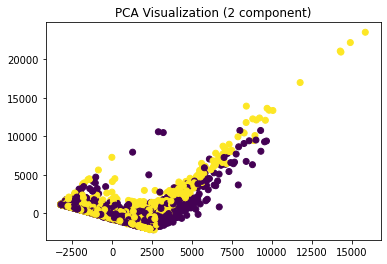

In [4]:
# Data visualization
# tSNE or PCA here

checkNotSubmitting()

pcaComps = 2
pca = PCA(n_components=pcaComps)
pca_train = pca.fit_transform(X_train, y_train)
pca_test = pca.transform(X_test)

if pcaComps == 2:
  plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train)
plt.title(f"PCA Visualization ({pcaComps} component)")
plt.show()

# Feature importance graphing
# todo
estimators=100 # todo: grid search me!
#gbc = GradientBoostingClassifier(n_estimators=100)
#gbc.fit(X_train, y_train)
# todo: render the important features
# look at my roommates code here: https://github.com/justincdavis/BowlGamesNN/blob/main/CFBowlGamesNN.ipynb

In [5]:
# Feature selection

checkNotSubmitting()

# can try filter, wrapper, and embedded methods: https://elearning.mines.edu/courses/40460/pages/instructional-learning-materials-feature-selection?module_item_id=529456
# todo...

In [6]:
# Feature extraction

checkNotSubmitting()

# we don't want to use tSNE, consider spectral embedding? maybe linear discriminant analysis?
# todo...

In [7]:
# Now we have the reduced dataset with high mutual information between each feature, time to run some models

In [8]:
# knn or svm?

checkNotSubmitting()

In [9]:
# Neural network

# Model parameters
activation = "sigmoid"
outputActivation = "sigmoid" # This should not change
hiddenExpansionSize = 50
denseHiddenLayers = 3
autoencoderCompressionSize = 6
##################

# Andrew's model arch notes:
# - do we progressively collapse when autoencoding or dense map straight to it?
# - mess around with dropout layers to reduce overfitting

checkNotSubmitting()

layers = []
layers.append(tf.keras.layers.Dense(hiddenExpansionSize, input_shape=(X.shape[1],), activation=activation, name=f"input_{X.shape[1]}x1"))
for i in range(denseHiddenLayers):
  layers.append(tf.keras.layers.Dense(hiddenExpansionSize, activation=activation, name=f"dense_{i}"))
layers.append(tf.keras.layers.Dense(autoencoderCompressionSize, activation=activation, name="autoenc"))
layers.append(tf.keras.layers.Dense(2, activation=outputActivation, name="output"))

dnn = tf.keras.Sequential(layers)
dnn.build()
dnn.summary()

nnDefaultWeights = dnn.get_weights()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11x1 (Dense)          (None, 50)                600       
                                                                 
 dense_0 (Dense)             (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 autoenc (Dense)             (None, 6)                 306       
                                                                 
 output (Dense)              (None, 2)                 14        
                                                                 
Total params: 8,570
Trainable params: 8,570
Non-trainabl

In [13]:
# Neural network compilation and training

# TRAINING PARAMETERS
learningRate = 0.001
#lossFunc = "binary_crossentropy"
lossFunc = "mae"
epochs = 30
batchSize = 1000
#####################

if not testSubmission:
  optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
  #optimizer = tf.keras.optimizers.SGD()

  dnn.compile(optimizer, loss=lossFunc, metrics=["accuracy"])

  dnn.set_weights(nnDefaultWeights) # Reset if we already fit
  dnn.fit(X_train, y_train, batch_size=batchSize, epochs=epochs)

  nnMetrics = dnn.evaluate(X_test, y_test)
  print(f"NN evaluated accuracy: {nnMetrics}")
else:
  predictions = dnn.predict(X_test.drop(columns=["PassengerId"]), batch_size=batchSize)
  # We have 2 output nodes, we want to take the index of the node with greater activation
  predictionsBinary = np.argmax(predictions, axis=1)
  predictionsBinary = 1 - predictionsBinary # Invert the result
  outData = pd.DataFrame()
  outData["PassengerId"] = X_test["PassengerId"]
  outData["Transported"] = predictionsBinary.astype(bool)
  outData.to_csv("results.csv", index=False)